# Importing module

In [138]:
!pip install xai
!pip install xai_data

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement xai_data (from versions: none)
ERROR: No matching distribution found for xai_data


In [139]:

import sys, os
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline

sys.path.append("..")

import xai
import xai.data

# Columns in Dataset

In [140]:
cat_columns = ["cat_columns", "job_title", "gender_full", "termreason_desc", "termtype_desc",
                   "STATUS", "BUSINESS_UNIT"]


In [141]:

# Loading the dataset
dataframe = pd.read_csv("/content/drive/MyDrive/content/MFG10YearTerminationData.csv")
dataframe.tail()



,EmployeeID,recorddate_key,birthdate_key,orighiredate_key,terminationdate_key,age,length_of_service,city_name,department_name,job_title,store_name,gender_short,gender_full,termreason_desc,termtype_desc,STATUS_YEAR,STATUS,BUSINESS_UNIT
49648,8258,12/1/2015 0:00,5/28/1994,8/19/2013,12/30/2015,21,2,Valemount,Dairy,Dairy Person,34,M,Male,Layoff,Involuntary,2015,TERMINATED,STORES
49649,8264,8/1/2013 0:00,6/13/1994,8/27/2013,8/30/2013,19,0,Vancouver,Customer Service,Cashier,44,F,Female,Resignaton,Voluntary,2013,TERMINATED,STORES
49650,8279,12/1/2015 0:00,7/18/1994,9/15/2013,12/30/2015,21,2,White Rock,Customer Service,Cashier,39,F,Female,Layoff,Involuntary,2015,TERMINATED,STORES
49651,8296,12/1/2013 0:00,9/2/1994,10/9/2013,12/31/2013,19,0,Kelowna,Customer Service,Cashier,16,F,Female,Resignaton,Voluntary,2013,TERMINATED,STORES
49652,8321,12/1/2014 0:00,11/28/1994,11/24/2013,12/30/2014,20,1,Grand Forks,Customer Service,Cashier,13,F,Female,Layoff,Involuntary,2014,TERMINATED,STORES


In [142]:


label = "loan"
protected_data = ["termreason_desc", "gender_full", "termtype_desc"]



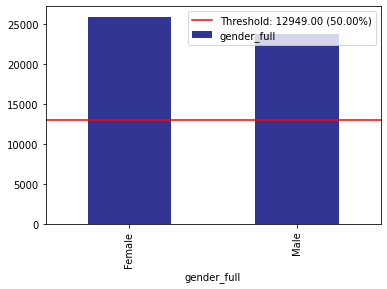

In [143]:
df_groups = xai.imbalance_plot(dataframe, "gender_full", categorical_cols=cat_columns)

# Imbalance and balance data in term type description as per gender

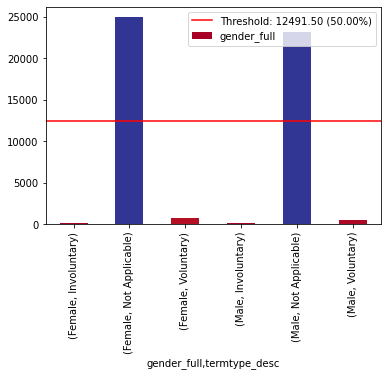

In [144]:
groups = xai.imbalance_plot(dataframe, "gender_full", "termtype_desc", categorical_cols=cat_columns)

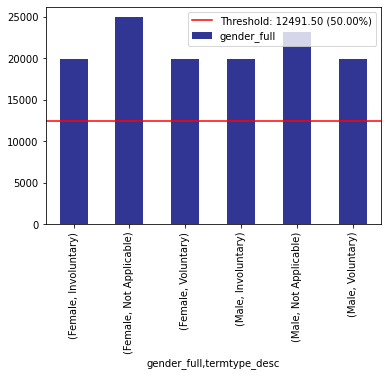

In [145]:
bal_dataframe = xai.balance(dataframe, "gender_full", "termtype_desc", upsample=0.8, categorical_cols=cat_columns)

# Imbalance and balance data of gender and status


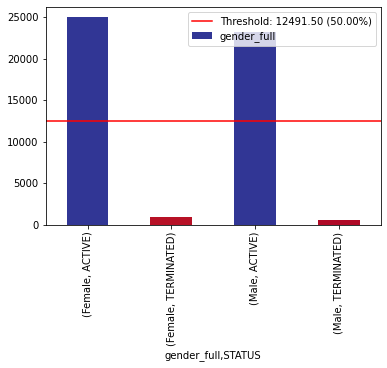

In [146]:
groups = xai.imbalance_plot(dataframe, "gender_full", "STATUS", categorical_cols=cat_columns)

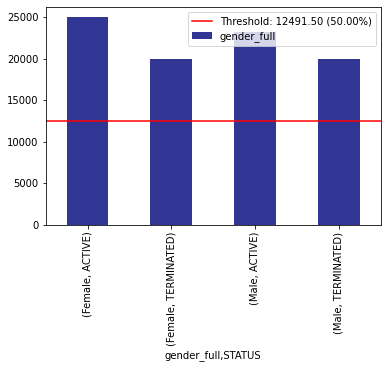

In [147]:
bal_dataframe = xai.balance(dataframe, "gender_full", "STATUS", upsample=0.8, categorical_cols=cat_columns)

# Correlation using Xai library

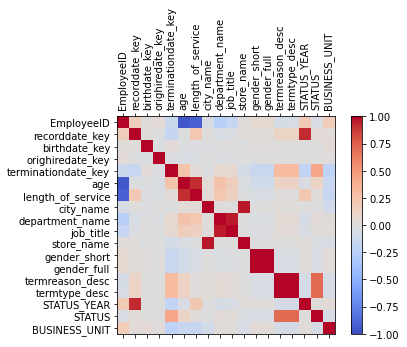

In [148]:
_ = xai.correlations(dataframe, include_categorical=True, plot_type="matrix")

Total number of rows:  2000


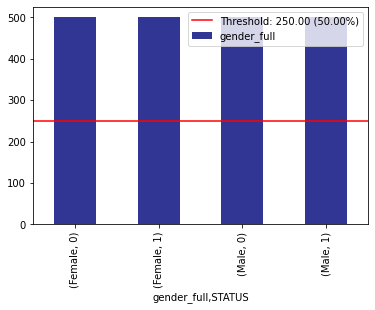

In [149]:
proc_dataframe = xai.normalize_numeric(bal_dataframe)
proc_dataframe = xai.convert_categories(proc_dataframe)
x = proc_dataframe.drop("STATUS", axis=1)
y = proc_dataframe["STATUS"]

x_train, y_train, x_test, y_test, train_idx, test_idx = \
    xai.balanced_train_test_split(
            x, y, "gender_full", 
            min_per_group=300,
            max_per_group=500,
            categorical_cols=cat_columns)

x_train_for_display = bal_dataframe[train_idx]
x_test_data_for_display = bal_dataframe[test_idx]

print("Total number of rows: ", x_test.shape[0])

dataframe_test = x_test_data_for_display.copy()
dataframe_test["STATUS"] = y_test

_= xai.imbalance_plot(dataframe_test, "gender_full", "STATUS", categorical_cols=cat_columns)

# Machine Learning models

# Logistic Regression

In [150]:

from sklearn.linear_model import LogisticRegression

clf=LogisticRegression()

#fitting the data
clf.fit(x_train, y_train)

#predicting
pred = clf.predict(x_test)



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [151]:
probabilities = clf.predict(x_test)

In [152]:
probabilities_test = clf.predict_proba(x_test)

In [153]:
x_test_data_for_display.columns

Index(['EmployeeID', 'recorddate_key', 'birthdate_key', 'orighiredate_key',
       'terminationdate_key', 'age', 'length_of_service', 'city_name',
       'department_name', 'job_title', 'store_name', 'gender_short',
       'gender_full', 'termreason_desc', 'termtype_desc', 'STATUS_YEAR',
       'STATUS', 'BUSINESS_UNIT'],
      dtype='object')

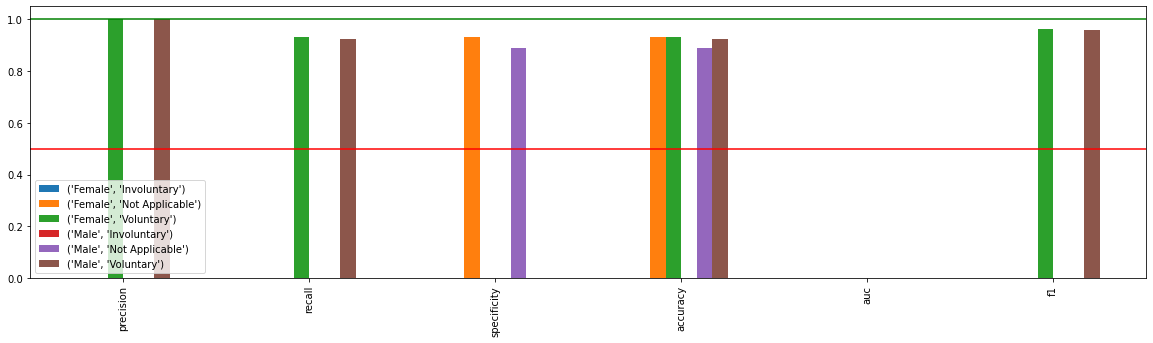

In [154]:


_ = xai.metrics_plot(
    y_test, 
    probabilities, 
    df=x_test_data_for_display, 
    cross_cols=["gender_full", "termtype_desc"],
    categorical_cols=cat_columns)

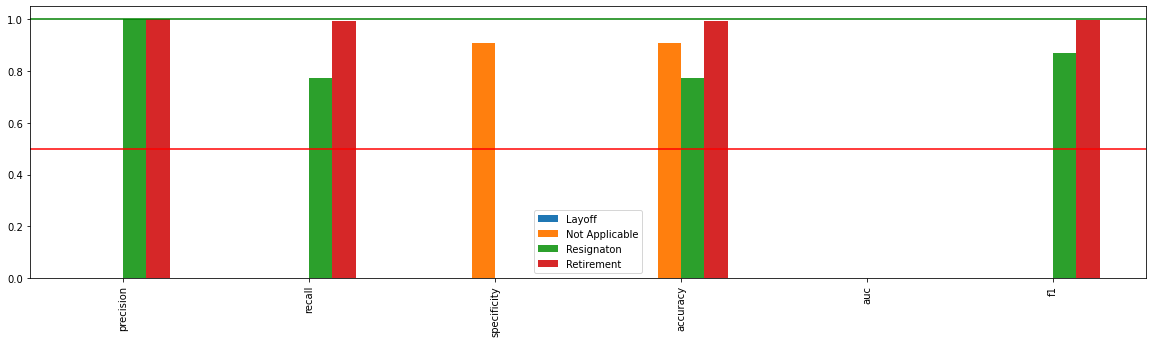

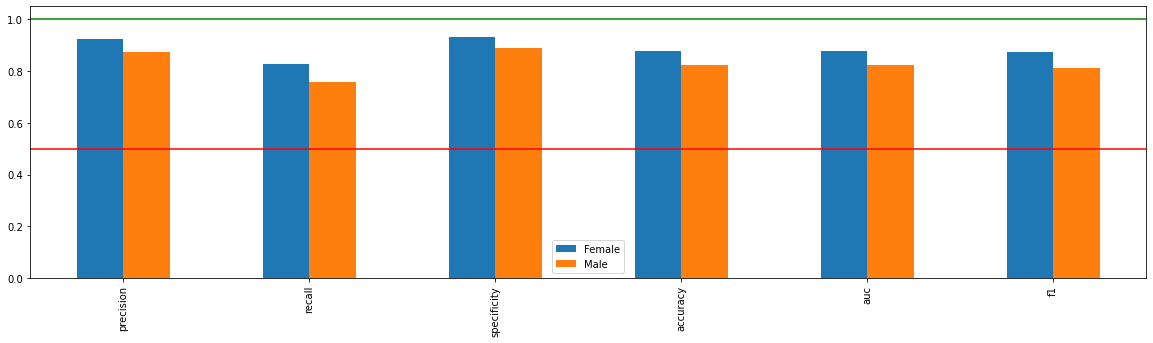

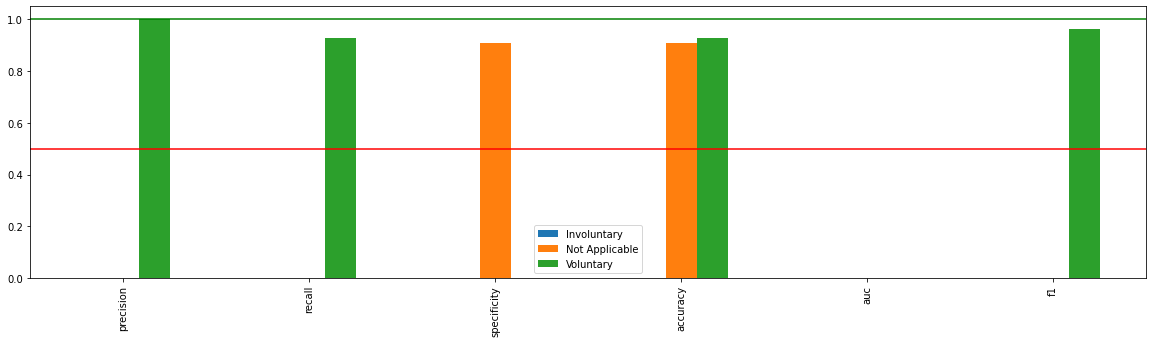

In [155]:
_ = [xai.metrics_plot(
    y_test, 
    probabilities, 
    df=x_test_data_for_display, 
    cross_cols=[p],
    categorical_cols=cat_columns) for p in protected_data]

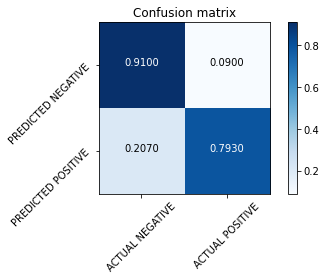

In [156]:
xai.confusion_matrix_plot(y_test, pred)

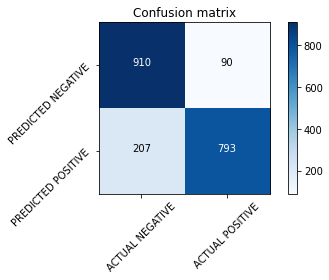

In [157]:


xai.confusion_matrix_plot(y_test, pred, scaled=False)

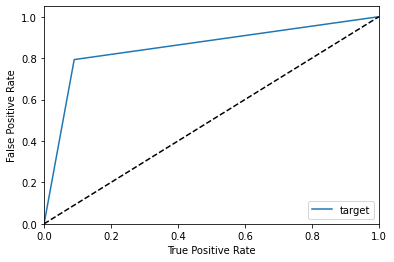

In [158]:
_ = xai.roc_plot(y_test, probabilities)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:991: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1000: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:991: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:991: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning,


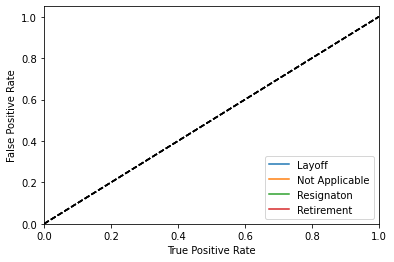

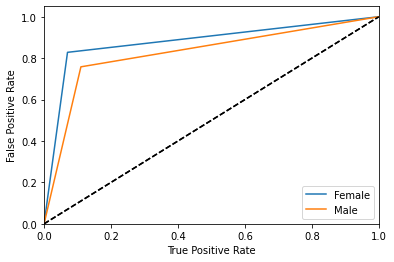

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:991: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1000: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:991: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning,


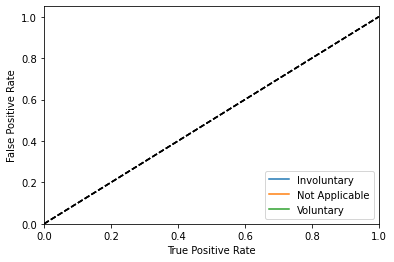

In [159]:
_ = [xai.roc_plot(
    y_test, 
    probabilities, 
    df=x_test_data_for_display, 
    cross_cols=[p],
    categorical_cols=cat_columns) for p in protected_data]

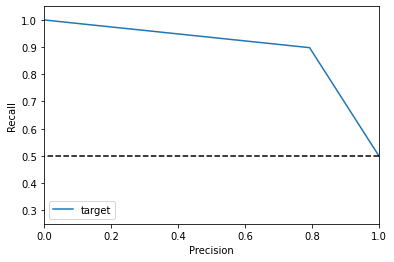

In [160]:


_= xai.pr_plot(y_test, probabilities)



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:863: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


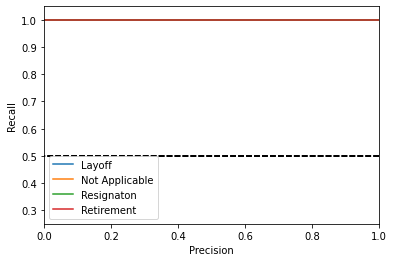

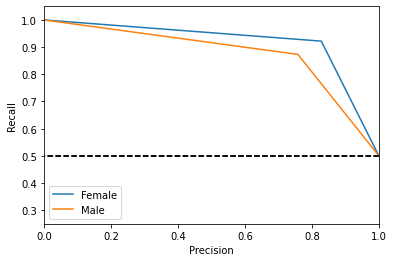

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:863: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


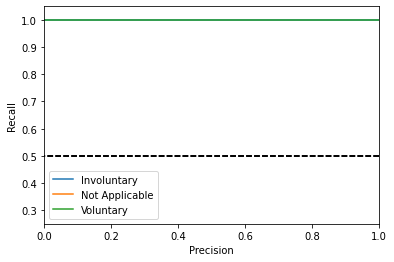

In [161]:
_ = [xai.pr_plot(
    y_test, 
    probabilities, 
    df=x_test_data_for_display, 
    cross_cols=[p],
    categorical_cols=cat_columns) for p in protected_data]

# Support Vector Machine

In [162]:

from sklearn.svm import SVC

clf=SVC()

#fitting the data
clf.fit(x_train, y_train)

#predicting
pred = clf.predict(x_test)



In [163]:
probabilities = clf.predict(x_test)

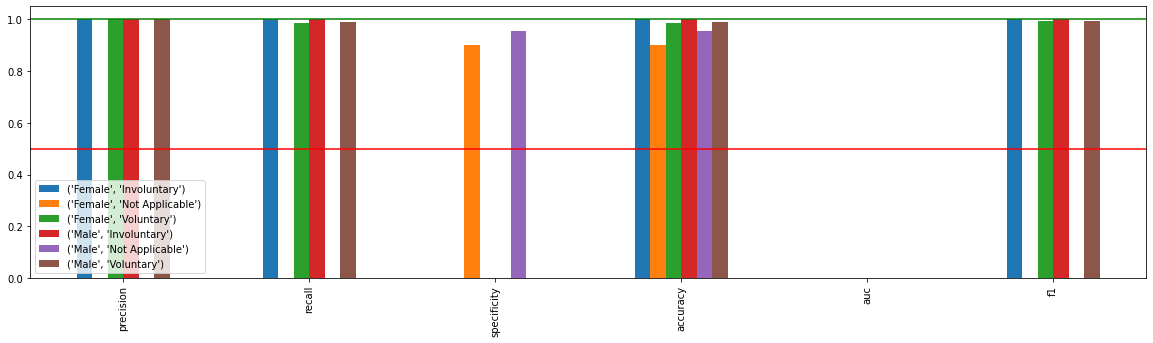

In [164]:


_ = xai.metrics_plot(
    y_test, 
    probabilities, 
    df=x_test_data_for_display, 
    cross_cols=["gender_full", "termtype_desc"],
    categorical_cols=cat_columns)

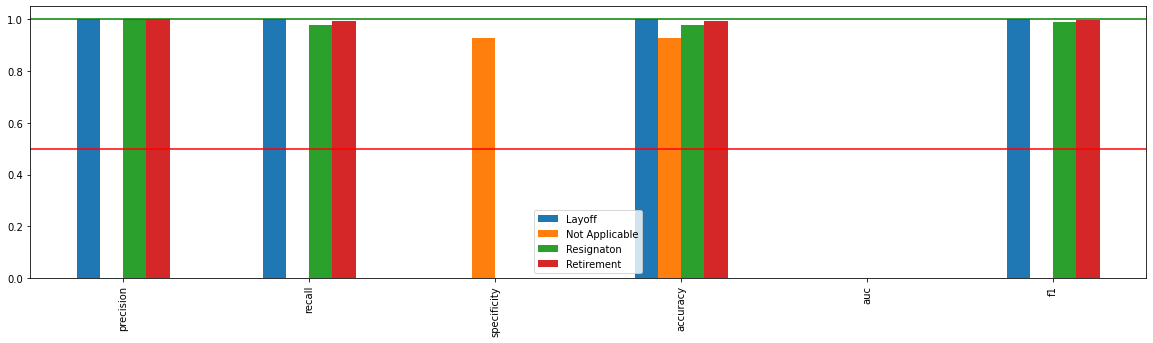

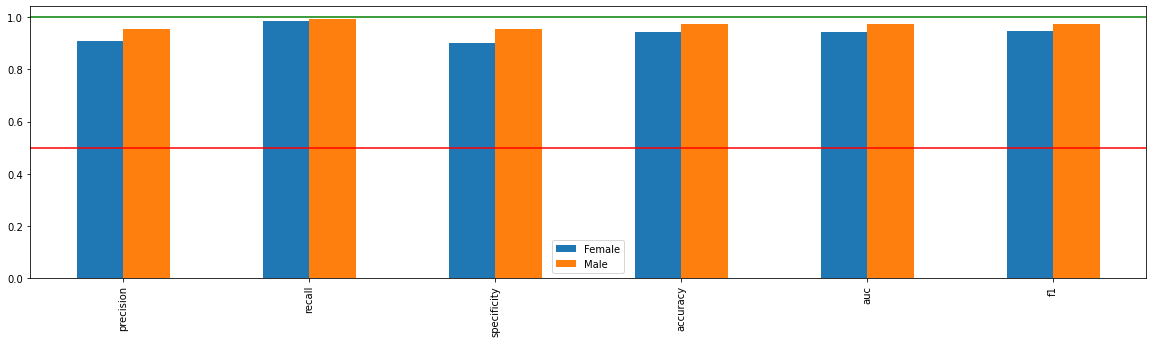

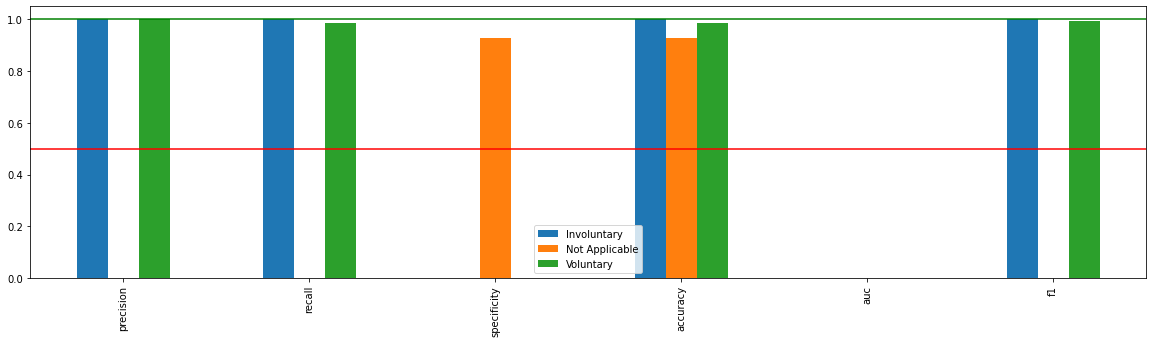

In [165]:
_ = [xai.metrics_plot(
    y_test, 
    probabilities, 
    df=x_test_data_for_display, 
    cross_cols=[p],
    categorical_cols=cat_columns) for p in protected_data]

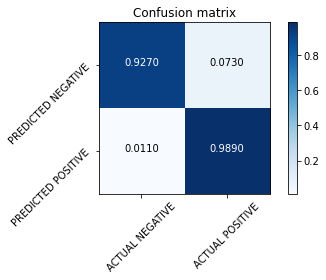

In [166]:
xai.confusion_matrix_plot(y_test, pred)

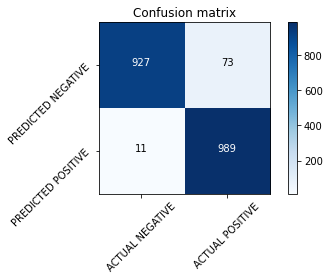

In [167]:


xai.confusion_matrix_plot(y_test, pred, scaled=False)

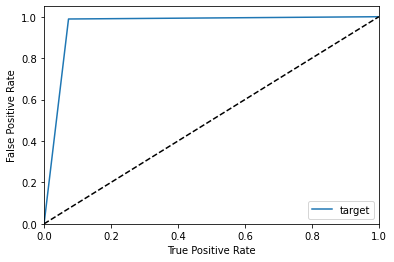

In [168]:
_ = xai.roc_plot(y_test, probabilities)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:991: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1000: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:991: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:991: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning,


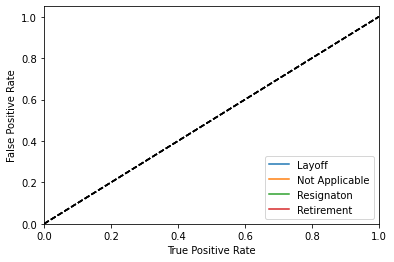

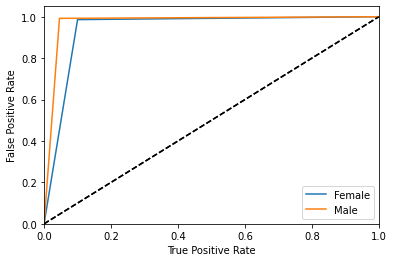

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:991: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1000: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:991: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning,


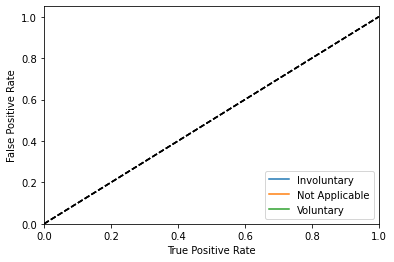

In [169]:
_ = [xai.roc_plot(
    y_test, 
    probabilities, 
    df=x_test_data_for_display, 
    cross_cols=[p],
    categorical_cols=cat_columns) for p in protected_data]

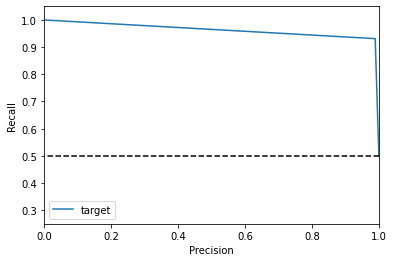

In [170]:


_= xai.pr_plot(y_test, probabilities)



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:863: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


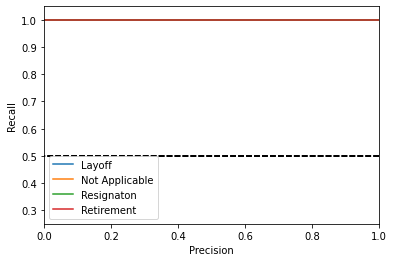

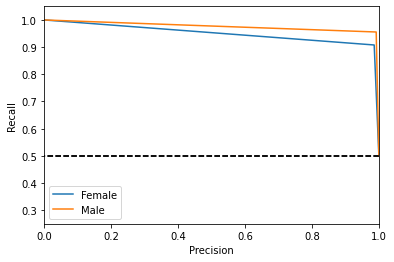

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:863: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


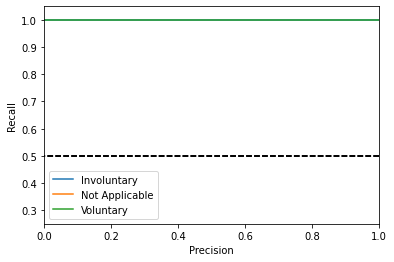

In [171]:
_ = [xai.pr_plot(
    y_test, 
    probabilities, 
    df=x_test_data_for_display, 
    cross_cols=[p],
    categorical_cols=cat_columns) for p in protected_data]